In [1]:
import torch
import numpy as np
import torch.optim as optim 
import math
import matplotlib.pyplot as plt
import matplotlib
from junctionart.roundabout.RoundaboutLaneEncodingEnv import RoundaboutLaneEncodingEnv
from junctionart.roundabout.GFNAgent2 import GFNAgent2
from junctionart.roundabout.FlowFunction import FlowFunction as FF
from tqdm import tqdm

# device = torch.device("mps")
N_values=10
vector_Len=4
N_epsiodes= 4000
threePoints = [
            {"x": 80, "y": 20, "heading": math.radians(45),'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
            {"x": 210, "y": 20, "heading": math.radians(115),'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
        ]
env = RoundaboutLaneEncodingEnv()

agent=GFNAgent2(generatorEnv=env, roadDefinitions = threePoints, vector_Len=vector_Len,N_values=N_values,batch_size=16)

Fnet=FF(state_dim=vector_Len, n_embed=vector_Len*N_values)
# Fnet.to(device)

# ff = FF(state_dim = 4, n_embed = vector_Len*N_values)
agent.reset()

optimizer = optim.Adam(Fnet.parameters(), lr=1e-4)


Match_loss_all=[]
AllRewards=[]
temp_start = 100
for Episode in tqdm(range(N_epsiodes)):
    temp = 1 if temp_start - 2*(Episode)*temp_start/N_epsiodes < 1 else temp_start - 2*(Episode)*temp_start/N_epsiodes

    agent.reset()
    #####forward, build the trajectory
    for step in range(vector_Len):
        states, rewards=agent.step_forward(Fnet, temp)

    #####calculate rewards
    AllRewards.append(rewards.mean().item())

    #####calculate flow match loss
    optimizer.zero_grad()

    Match_loss=agent.CalculateFlowMatchingLoss(Fnet, rewards)
    Match_loss_all.append(Match_loss.item())

    Match_loss.backward()

    optimizer.step()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [04:44<00:00, 14.04it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.40it/s]


<AxesSubplot:xlabel='X', ylabel='Y'>

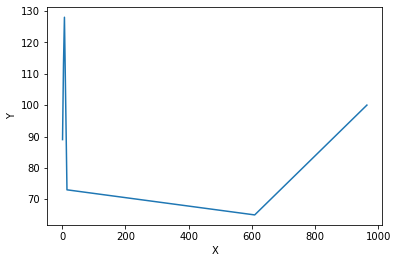

In [4]:
import seaborn as sns
import pandas as pd
statesForPlot = []
rewardsForPlot = []
for Episode in tqdm(range(100)): 
    temp = 1
    agent.reset()

    for step in range(vector_Len):
        states, rewards=agent.step_forward(Fnet, temp)

    statesForPlot.extend(states)
    rewardsForPlot.extend(rewards)

stateDict = {}
for i in range(len(statesForPlot)):
    state = str(statesForPlot[i].tolist())
    if state in stateDict:
        reward, freq = stateDict[state]
        stateDict[state] = (reward, freq + 1)
    else:
        stateDict[state] = (rewardsForPlot[i], 1)

rewards = []
freqs = []
for _ in stateDict:
    reward, freq = stateDict[_]
    rewards.append(reward.item())
    freqs.append(freq)

sns.scatterplot(data=pd.DataFrame({'Frequency':freqs, 'Reward':rewards}), x='Frequency', y='Reward', size='Reward')  

<AxesSubplot:xlabel='Frequency', ylabel='Reward'>

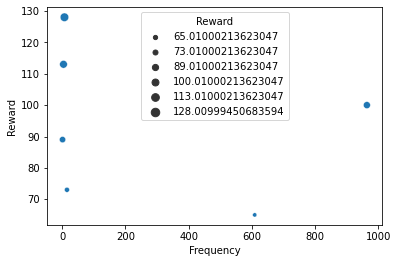

In [7]:
sns.scatterplot(data=pd.DataFrame({'Frequency':freqs, 'Reward':rewards}), x='Frequency', y='Reward', size='Reward')  

## With Temperature (100 -> 1) 

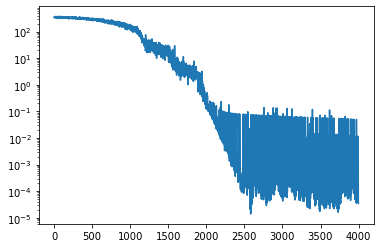

In [2]:
plt.plot(Match_loss_all)
plt.yscale('log')
plt.show()

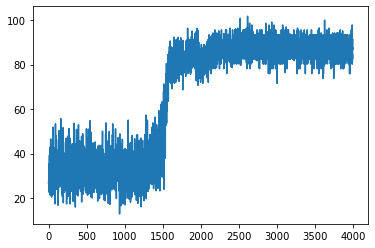

In [3]:
plt.plot(AllRewards)
# plt.yscale('log')
plt.show()

## Without tempareture (T = 1) 

tensor([[1., 2., 5., 4.],
        [1., 2., 5., 4.],
        [1., 2., 5., 4.],
        [1., 2., 5., 4.],
        [1., 2., 5., 4.],
        [1., 2., 5., 4.],
        [1., 2., 5., 4.],
        [1., 2., 5., 4.],
        [1., 2., 5., 4.],
        [1., 2., 5., 4.],
        [1., 2., 5., 4.],
        [1., 2., 5., 4.],
        [1., 2., 5., 4.],
        [1., 2., 5., 4.],
        [1., 2., 5., 4.],
        [1., 2., 5., 4.]])

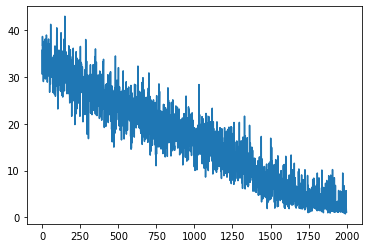

In [4]:
plt.plot(torch.arange(N_epsiodes), Match_loss_all)
# plt.yscale('log')
plt.show()

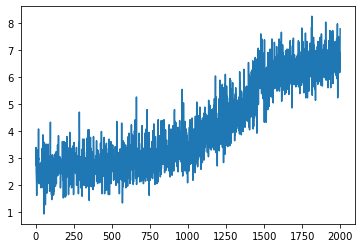

In [5]:
plt.plot(torch.arange(N_epsiodes), AllRewards)
# plt.yscale('log')
plt.show()